In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorboard.plugins import projector

c:\Users\prave\Sentiment_Analysis\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
BATCH_SIZE = 64

In [4]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split = ['train', 'test[:50%]', 'test[50%:]'],as_supervised = True)

In [5]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
for review, label in val_ds.take(2):
    print(review)
    print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [7]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>","")
    output = tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [8]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [9]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [10]:
vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

In [11]:
training_data = train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [12]:
len(vectorize_layer.get_vocabulary())

10000

In [13]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [14]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [15]:
vectorize_layer.get_vocabulary()[411]

np.str_('absolutely')

In [16]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [17]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn = tf.keras.layers.SimpleRNN(25)
output = simple_rnn(inputs)
print(output.shape)

(32, 25)


In [21]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
os.makedirs("sentiment_analysis/checkpoints", exist_ok=True)
os.makedirs("sentiment_analysis/final_model", exist_ok=True)

checkpoint_filepath = "sentiment_analysis/checkpoints/best_model.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False)

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,)
    #callbacks=[model_checkpoint_callback])

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5052 - loss: 0.6947 - val_accuracy: 0.5238 - val_loss: 0.6924
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.6038 - loss: 0.6662 - val_accuracy: 0.6430 - val_loss: 0.6428
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7198 - loss: 0.5705 - val_accuracy: 0.7228 - val_loss: 0.5653
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8035 - loss: 0.4650 - val_accuracy: 0.7401 - val_loss: 0.5272
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8467 - loss: 0.3860 - val_accuracy: 0.7375 - val_loss: 0.5416
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.8616 - loss: 0.3522 - val_accuracy: 0.7444 - val_loss: 0.5556
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8642 - loss: 0.3384 - val_accuracy: 0.7377 - val_loss: 0.5749
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8724 - loss: 0.3231 - 

In [36]:
model.save("sentiment_analysis/final_model/trained_model.keras")

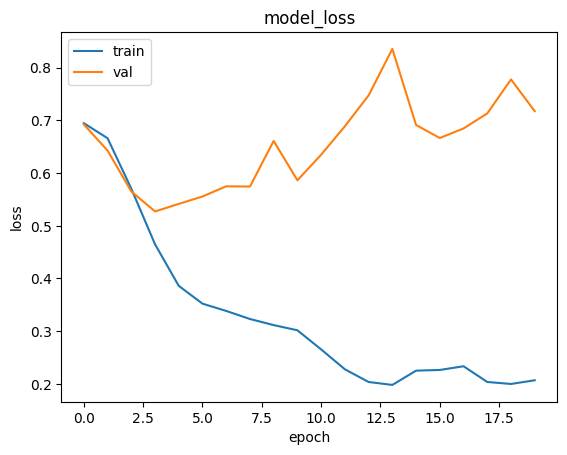

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

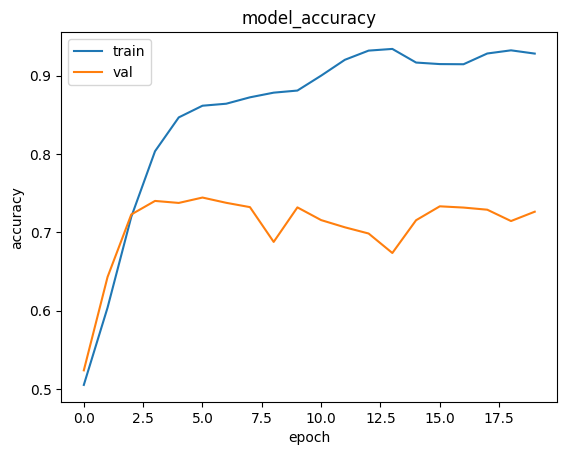

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9620 - loss: 0.1354


[0.1353730410337448, 0.9620400071144104]

In [44]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
checkpoint_filepath = "sentiment_analysis/checkpoints/LSTM.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [46]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [47]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 169s 411ms/step - accuracy: 0.6142 - loss: 0.6360 - val_accuracy: 0.7918 - val_loss: 0.4569
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 176s 325ms/step - accuracy: 0.8607 - loss: 0.3505 - val_accuracy: 0.8527 - val_loss: 0.3532
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 131s 334ms/step - accuracy: 0.9054 - loss: 0.2627 - val_accuracy: 0.8471 - val_loss: 0.3868
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 311ms/step - accuracy: 0.9208 - loss: 0.2259 - val_accuracy: 0.8514 - val_loss: 0.4020
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 113s 290ms/step - accuracy: 0.9272 - loss: 0.2133 - val_accuracy: 0.8500 - val_loss: 0.4116
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.9322 - loss: 0.1944 - val_accuracy: 0.8474 - val_loss: 0.3679
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 118s 302ms/step - accuracy: 0.9462 - loss: 0.1691 - val_accuracy: 0.8126 - val_loss: 0.4454
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.9479 -

In [48]:
model.save("sentiment_analysis/final_model/trained_model_LSTM.keras")

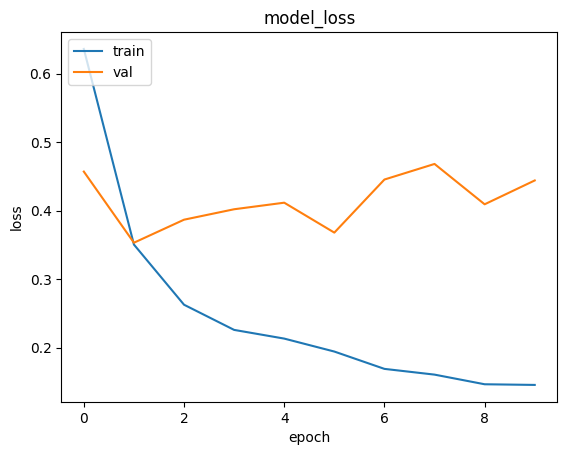

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

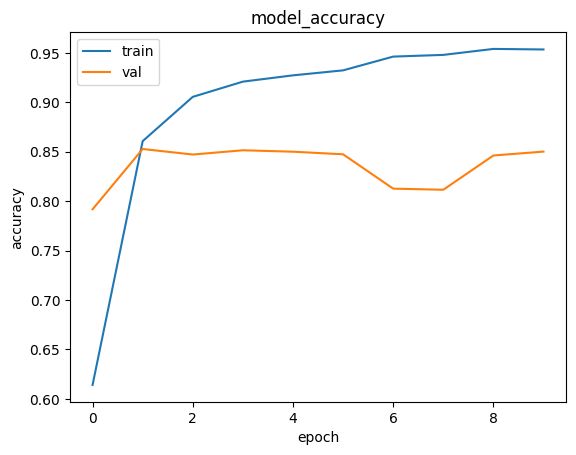

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.8508 - loss: 0.4434


[0.44336003065109253, 0.8507999777793884]

In [19]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_filepath = "sentiment_analysis/checkpoints/GRU.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 127s 310ms/step - accuracy: 0.5310 - loss: 0.6913 - val_accuracy: 0.5926 - val_loss: 0.6827
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 132s 337ms/step - accuracy: 0.7685 - loss: 0.4893 - val_accuracy: 0.8153 - val_loss: 0.4110
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 129s 329ms/step - accuracy: 0.8699 - loss: 0.3327 - val_accuracy: 0.8296 - val_loss: 0.3886
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.9034 - loss: 0.2629 - val_accuracy: 0.8445 - val_loss: 0.3855
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 125s 319ms/step - accuracy: 0.9223 - loss: 0.2199 - val_accuracy: 0.8508 - val_loss: 0.3748
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.9308 - loss: 0.1999 - val_accuracy: 0.8459 - val_loss: 0.3837
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 123s 316ms/step - accuracy: 0.9380 - loss: 0.1845 - val_accuracy: 0.8462 - val_loss: 0.3966
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 128s 328ms/step - accuracy: 0.9373 -

In [23]:
model.save("sentiment_analysis/final_model/trained_model_GRU.keras")

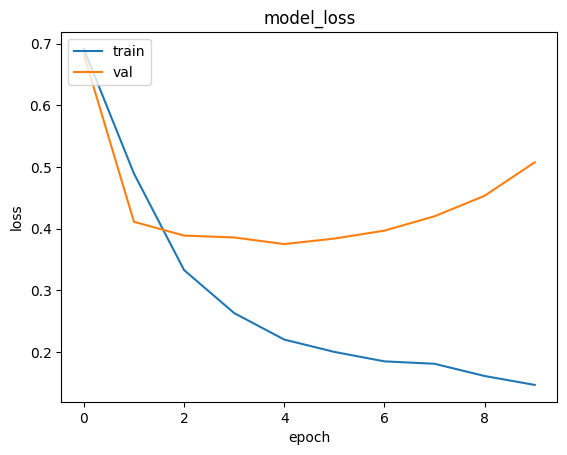

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

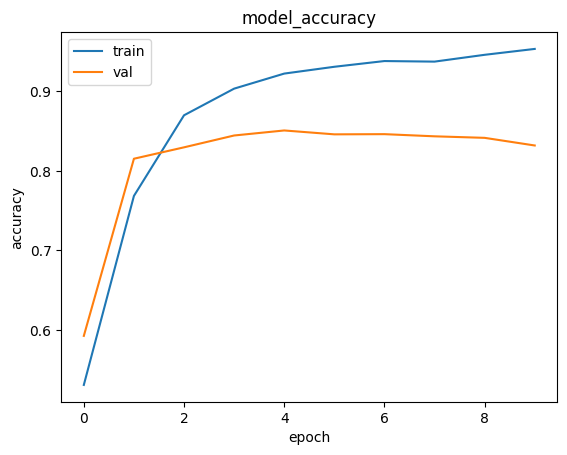

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.8304 - loss: 0.5096


[0.5096120238304138, 0.8303999900817871]